In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['axes.unicode_minus'] = False

# 제 1절 서론

In [2]:
df = pd.read_csv('./data/5장 - 계절형 ARIMA/표5.1-우리나라의실업률자료.txt', header=None)
df.columns = ['z']

date = pd.date_range('1982-7-1', '1992-6-30', freq='M')
df['year'] = date.year
df['month'] = date.month

lst_idx = []

for i in range(len(df)):
    year = df.loc[i]['year']
    year = str(year)[2:]
    year = int(float(year))
    month = int(df.loc[i]['month'])
    month = str(month)
    if len(month) != 2:
        month = '0' + month
        
    idx = '{}/{}'.format(month, year)
    
    lst_idx.append(idx)

df.index = lst_idx
df = df[['year', 'month', 'z']]

In [3]:
df

,year,month,z
07/82,1982,7,4.0
08/82,1982,8,3.9
09/82,1982,9,3.5
10/82,1982,10,3.2
11/82,1982,11,4.0
...,...,...,...
02/92,1992,2,3.1
03/92,1992,3,2.7
04/92,1992,4,2.4
05/92,1992,5,2.2


## 그림 5.1

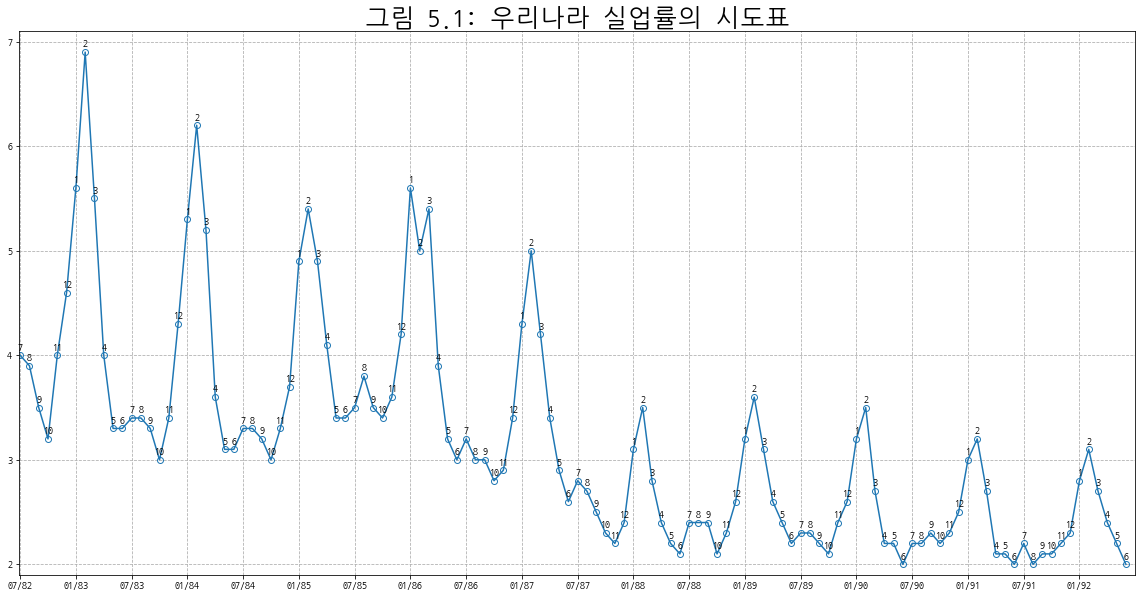

In [4]:
plt.title('그림 5.1: 우리나라 실업률의 시도표', fontsize=25)
plt.plot(df['z'], marker='o', markerfacecolor='none')
plt.xlim(-0.1, len(df))
plt.ylim(1.9, 7.1)
plt.xticks(df.index[::6])
plt.grid(True, linestyle='--')

for i in range(len(df)):
    height = df['z'][i]
    plt.text(df.index[i], height+0.05, df['month'][i], ha='center')
    
plt.show()

## 그림 5.2

In [5]:
# 멱변환
def power_transformation(value):
    return - 1 / np.sqrt(value)

df['w'] = power_transformation(df['z'])

In [6]:
df

,year,month,z,w
07/82,1982,7,4.0,-0.500000
08/82,1982,8,3.9,-0.506370
09/82,1982,9,3.5,-0.534522
10/82,1982,10,3.2,-0.559017
11/82,1982,11,4.0,-0.500000
...,...,...,...,...
02/92,1992,2,3.1,-0.567962
03/92,1992,3,2.7,-0.608581
04/92,1992,4,2.4,-0.645497
05/92,1992,5,2.2,-0.674200


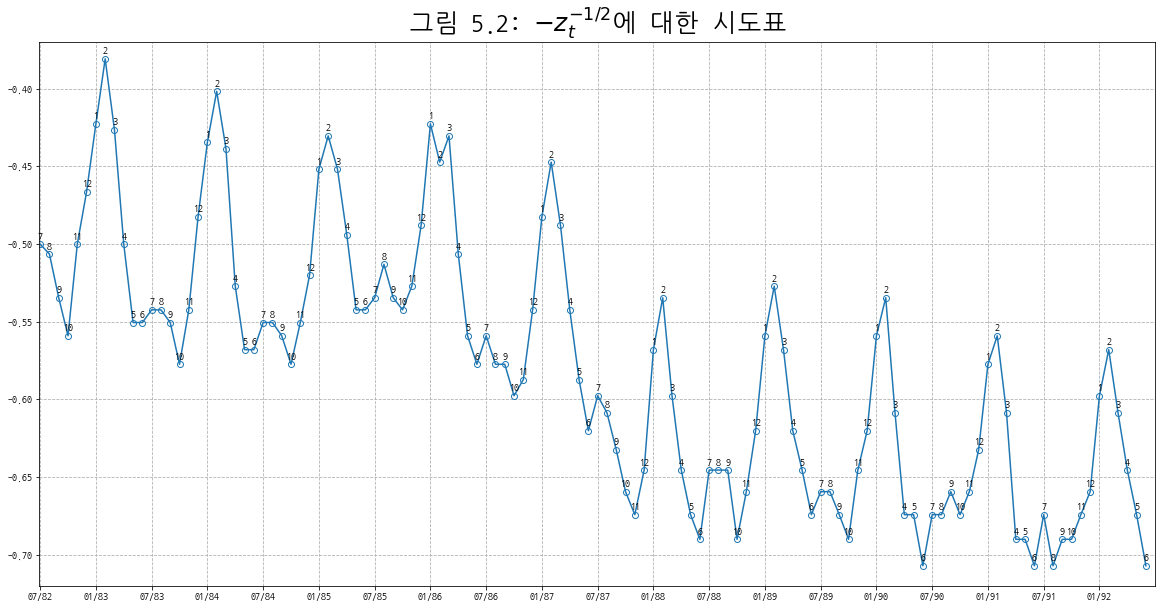

In [7]:
plt.title('그림 5.2: {}에 대한 시도표'.format('$-z_{t}^{-1/2}$'), fontsize=25)
plt.plot(df['w'], marker='o', markerfacecolor='none')
plt.xlim(-0.1, len(df))
plt.ylim(-0.72, -0.37)
plt.xticks(df.index[::6])
plt.grid(True, linestyle='--')

for i in range(len(df)):
    height = df['w'][i]
    plt.text(df.index[i], height+0.003, df['month'][i], ha='center')
    
plt.show()

## 그림 5.3

In [8]:
# 1차 차분
df['diff_w'] = df['w'].diff(1)

In [9]:
df

,year,month,z,w,diff_w
07/82,1982,7,4.0,-0.500000,NaN
08/82,1982,8,3.9,-0.506370,-0.006370
09/82,1982,9,3.5,-0.534522,-0.028153
10/82,1982,10,3.2,-0.559017,-0.024495
11/82,1982,11,4.0,-0.500000,0.059017
...,...,...,...,...,...
02/92,1992,2,3.1,-0.567962,0.029652
03/92,1992,3,2.7,-0.608581,-0.040619
04/92,1992,4,2.4,-0.645497,-0.036917
05/92,1992,5,2.2,-0.674200,-0.028703


posx and posy should be finite values
posx and posy should be finite values


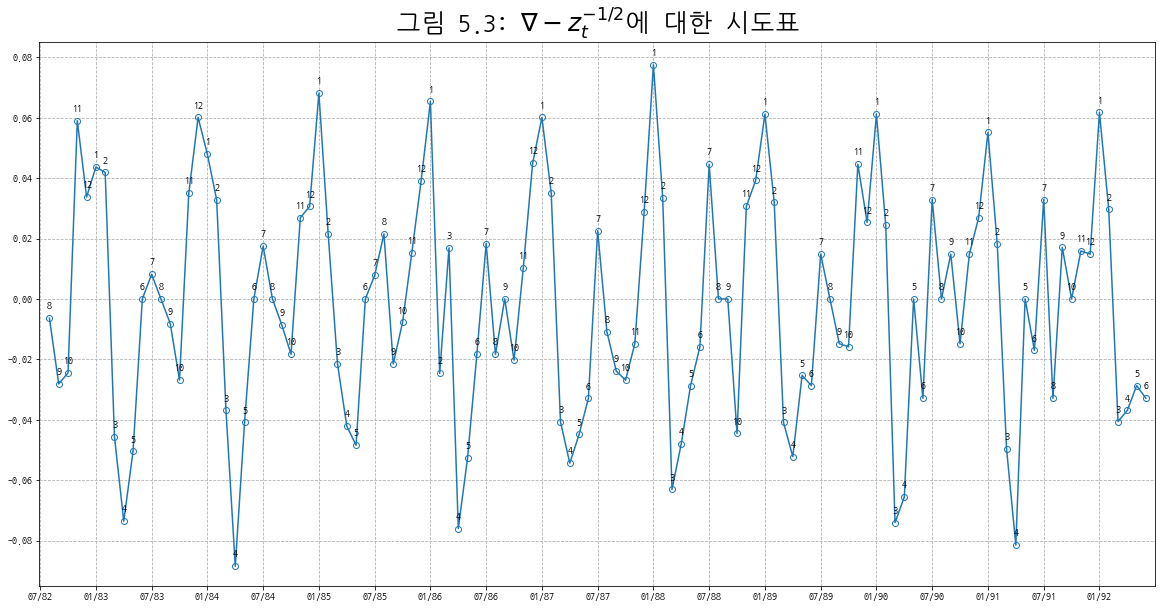

In [10]:
plt.title('그림 5.3: {}에 대한 시도표'.format('$\\nabla -z_{t}^{-1/2}$'), fontsize=25)
plt.plot(df['diff_w'], marker='o', markerfacecolor='none')
plt.xlim(-0.1, len(df))
plt.ylim(-0.095, 0.085)
plt.xticks(df.index[::6])
plt.grid(True, linestyle='--')

for i in range(len(df)):
    height = df['diff_w'][i]
    plt.text(df.index[i], height+0.003, df['month'][i], ha='center')
    
plt.show()

# 제 2절 계절형 시계열을 위한 ARIMA 모형

## 그림 5.4

In [11]:
# 12차 차분
df['X'] = df['diff_w'].diff(12)

In [12]:
df

,year,month,z,w,diff_w,X
07/82,1982,7,4.0,-0.500000,NaN,NaN
08/82,1982,8,3.9,-0.506370,-0.006370,NaN
09/82,1982,9,3.5,-0.534522,-0.028153,NaN
10/82,1982,10,3.2,-0.559017,-0.024495,NaN
11/82,1982,11,4.0,-0.500000,0.059017,NaN
...,...,...,...,...,...,...
02/92,1992,2,3.1,-0.567962,0.029652,0.011319
03/92,1992,3,2.7,-0.608581,-0.040619,0.008945
04/92,1992,4,2.4,-0.645497,-0.036917,0.044568
05/92,1992,5,2.2,-0.674200,-0.028703,-0.028703


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


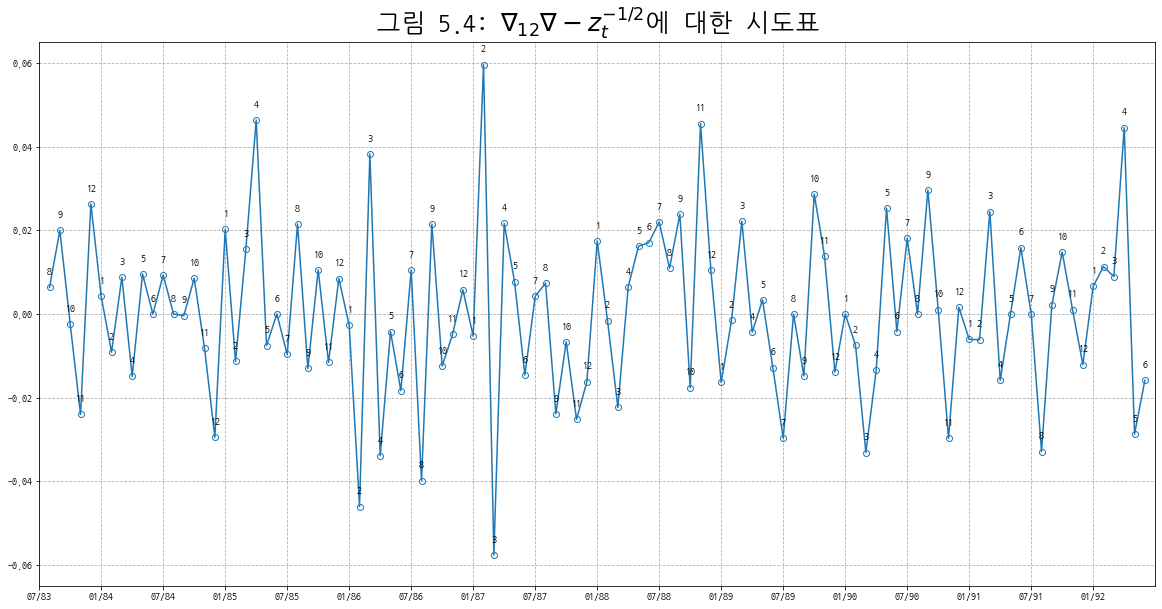

In [13]:
plt.title('그림 5.4: {}에 대한 시도표'.format('$\\nabla_{12} \\nabla -z_{t}^{-1/2}$'), fontsize=25)
plt.plot(df['X'], marker='o', markerfacecolor='none')
plt.xlim(13, len(df))
plt.ylim(-0.065, 0.065)
plt.xticks(df.index[12::6])
plt.grid(True, linestyle='--')

for i in range(len(df)):
    height = df['X'][i]
    plt.text(df.index[i], height+0.003, df['month'][i], ha='center')
    
plt.show()

# 제 3절 계절형 ARIMA 모형의 식별·추정·검진·예측

## 3.1 모형식별의 단계

### 그림 5.5

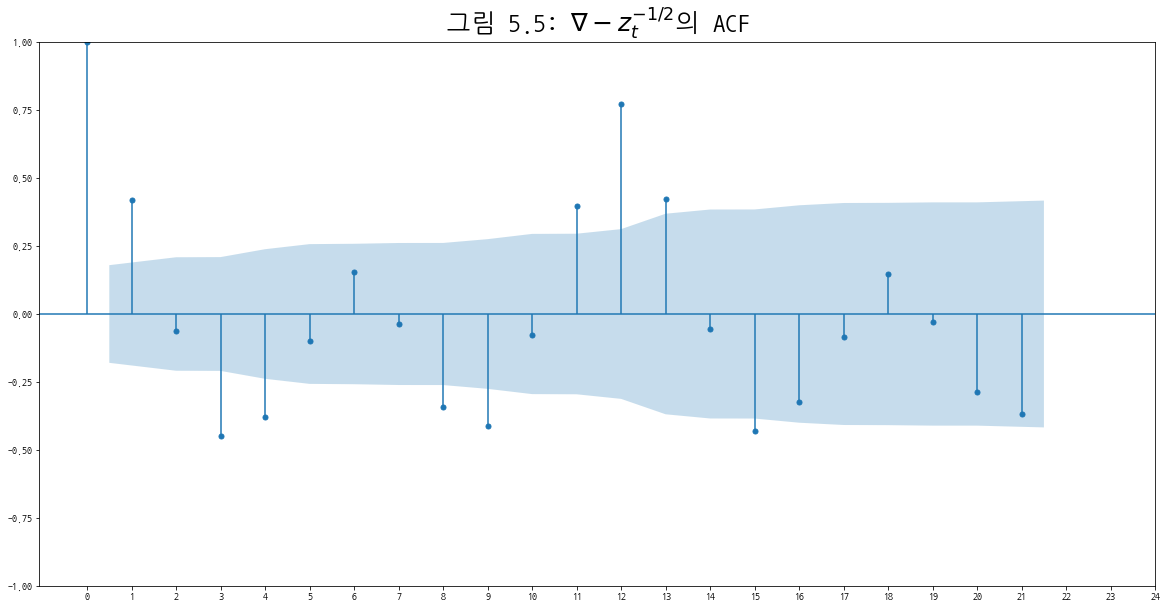

In [14]:
plot_acf(df['diff_w'][1:])
plt.title('그림 5.5: {}의 ACF'.format('$\\nabla -z_{t}^{-1/2}$'), fontsize=25)
plt.xticks(range(0, 25))
plt.show()

### 그림 5.6

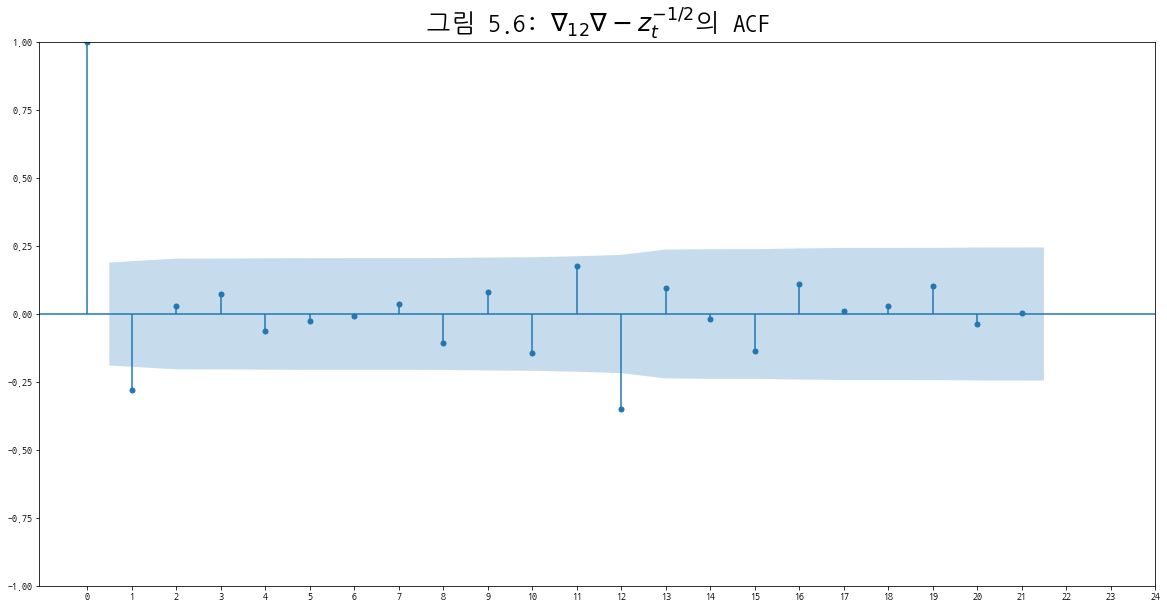

In [15]:
plot_acf(df['X'][13:])
plt.title('그림 5.6: {}의 ACF'.format('$\\nabla_{12} \\nabla -z_{t}^{-1/2}$'), fontsize=25)
plt.xticks(range(0, 25))
plt.show()

### 그림 5.7

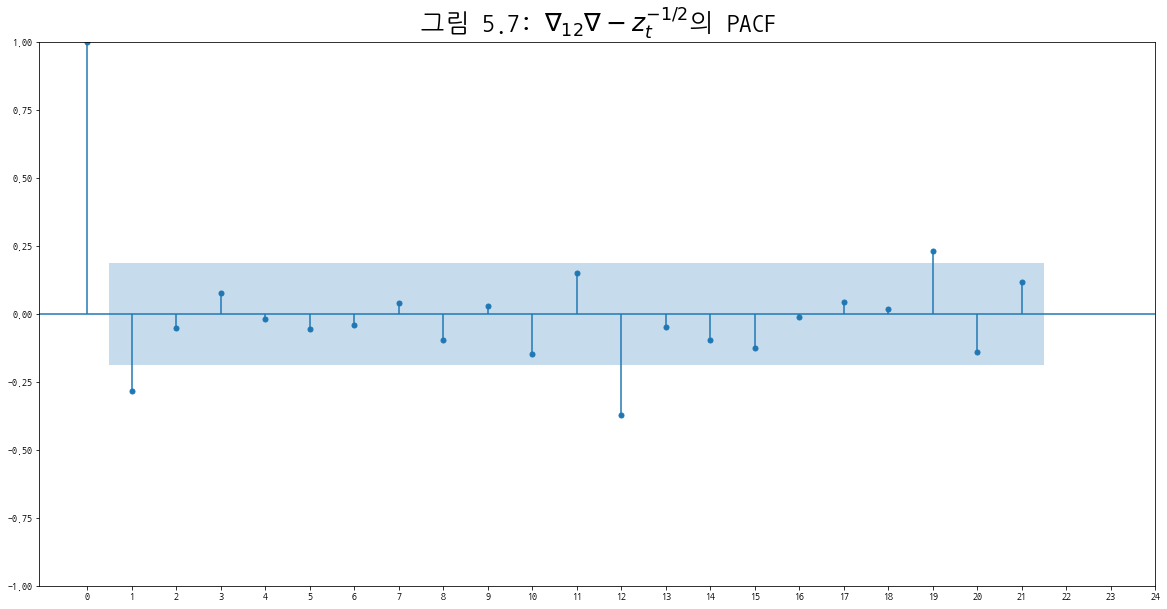

In [16]:
plot_pacf(df['X'][13:])
plt.title('그림 5.7: {}의 PACF'.format('$\\nabla_{12} \\nabla -z_{t}^{-1/2}$'), fontsize=25)
plt.xticks(range(0, 25))
plt.show()

## 3.2 모형추정의 단계

### 표 5.4 ARIMA$(0,1,1) × (0,1,1)_{12}$ 모형의 ML 추정치

In [17]:
model = sm.tsa.SARIMAX(df['w'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), trend='c')
result = model.fit()
print(result.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34161D+00    |proj g|=  1.06711D+01

At iterate    5    f= -2.35578D+00    |proj g|=  1.68204D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     23      1     0     0   1.682D-02  -2.356D+00
  F =  -2.3557751105846996     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                           


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


### 표 5.5 상수항이 없는 ARIMA$(0,1,1) × (0,1,1)_{12}$ 모형의 ML 추정치

In [18]:
model = sm.tsa.SARIMAX(df['w'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
result = model.fit()
print(result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34133D+00    |proj g|=  1.06716D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      8      1     0     0   1.702D-02  -2.355D+00
  F =  -2.3552821562540349     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


                                     SARIMAX Results                                      
Dep. Variable:                                  w   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 282.634
Date:                            Thu, 04 May 2023   AIC                           -559.268
Time:                                    17:47:40   BIC                           -551.249
Sample:                                07-01-1982   HQIC                          -556.017
                                     - 06-01-1992                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2978      0.089     -3.361      0.001      -0.471      -0.124
ma.S.L12      -0.5591      0.087   

## 모형검진의 단계

In [19]:
# 모델의 잔차
residuals = result.resid

### 그림 5.8

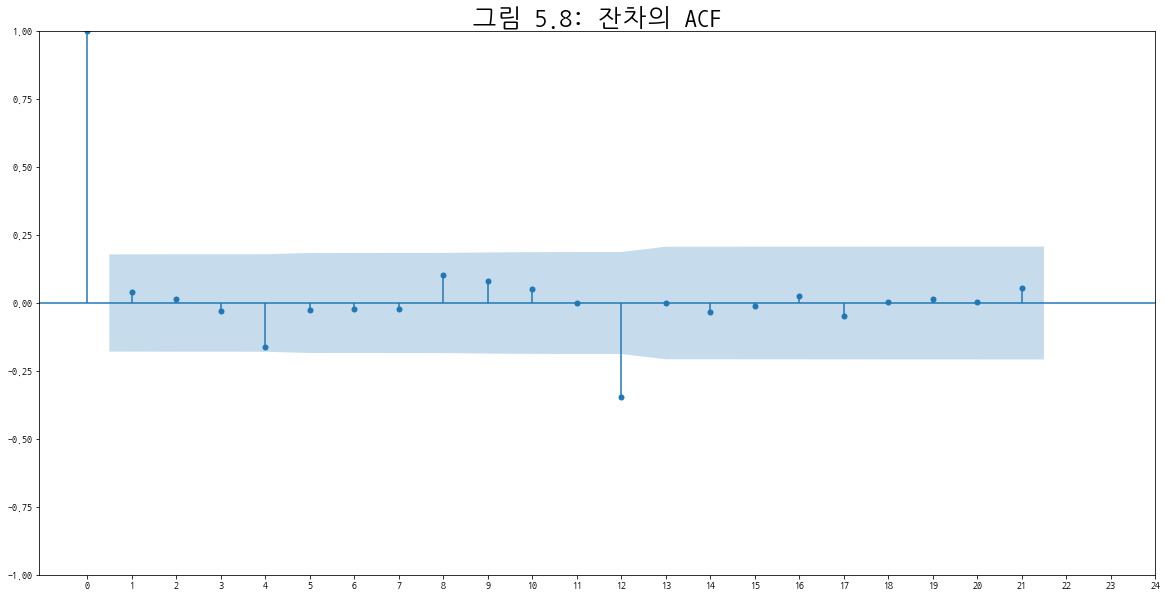

In [20]:
plot_acf(residuals)
plt.title('그림 5.8: 잔차의 ACF', fontsize=25)
plt.xticks(range(0, 25))
plt.show()

### 그림 5.9

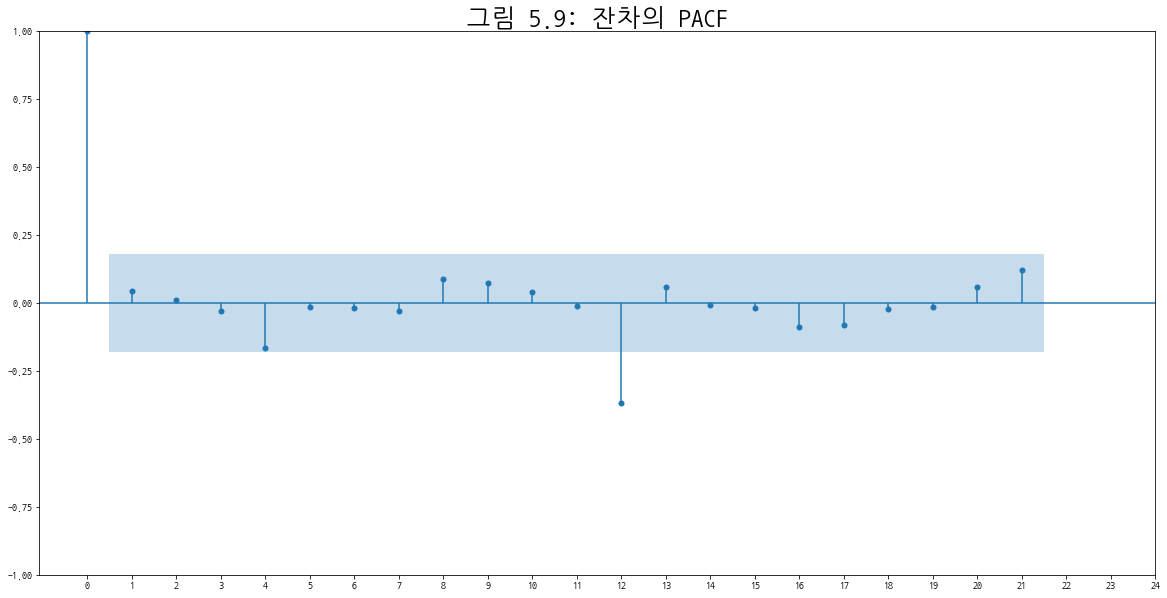

In [21]:
plot_pacf(residuals)
plt.title('그림 5.9: 잔차의 PACF', fontsize=25)
plt.xticks(range(0, 25))
plt.show()

### 표 5.6

In [22]:
# 포트만트 검정
portmanteau = acorr_ljungbox(residuals, lags=24)
portmanteau

,lb_stat,lb_pvalue
1,0.217189,0.641190
2,0.238754,0.887473
3,0.339432,0.952450
4,3.623275,0.459383
5,3.714287,0.591239
6,3.770369,0.707718
7,3.831770,0.798938
8,5.216807,0.734172
9,6.058023,0.734097
10,6.397150,0.780866


In [23]:
portmanteau[5::6]

,lb_stat,lb_pvalue
6,3.770369,0.707718
12,22.577408,0.031536
18,23.158855,0.184559
24,23.924426,0.465926


# 제 4절 모형선택의 기준

In [24]:
order = [(0,1,1), (0,1,1), (0,1,2), (1,1,0), (1,1,1)]
seasonal_order = [(0,1,1,12), (0,1,2,12), (0,1,1,12), (0,1,1,12), (0,1,1,12)]

In [25]:
df_result = pd.DataFrame(columns=['모형', 'AIC'])

lst_model = []
lst_aic = []
for o, s in zip(order, seasonal_order):
    model = sm.tsa.SARIMAX(df['w'], order=o, seasonal_order=s)
    result = model.fit()
    
    lst_model.append('ARIMA'+'{}'.format(o)+'×'+'{}'.format(s))
    lst_aic.append(result.aic)
    
df_result['모형'] = lst_model
df_result['AIC'] = lst_aic

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34133D+00    |proj g|=  1.06716D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      8      1     0     0   1.702D-02  -2.355D+00
  F =  -2.3552821562540349     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.2

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.28840D+00    |proj g|=  9.88394D-01

At iterate   10    f= -2.31169D+00    |proj g|=  1.45650D+01

At iterate   15    f= -2.35988D+00    |proj g|=  1.83641D-01

At iterate   20    f= -2.36036D+00    |proj g|=  1.70628D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -2.36193D+00    |proj g|=  2.94207D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     61      2     0     0   2.981D-02  -2.362D+00
  F =  -2.3619273566358379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.33566D+00    |proj g|=  1.08895D+01


 This problem is unconstrained.



At iterate    5    f= -2.35058D+00    |proj g|=  9.11292D-02

At iterate   10    f= -2.35130D+00    |proj g|=  2.79456D+00

At iterate   15    f= -2.35588D+00    |proj g|=  8.45854D-02

At iterate   20    f= -2.35622D+00    |proj g|=  1.72352D-02

At iterate   25    f= -2.35645D+00    |proj g|=  8.47077D-03

At iterate   30    f= -2.35652D+00    |proj g|=  9.38052D-02

At iterate   35    f= -2.35653D+00    |proj g|=  1.94254D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     62      1     0     0   1.943D-02  -2.357D+00
  F =  -2.3565309583465037     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -2.34931D+00    |proj g|=  4.30002D-01

At iterate   15    f= -2.34973D+00    |proj g|=  8.81398D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     23      1     0     0   1.675D-02  -2.350D+00
  F =  -2.3497345854637657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.33987D+00    |proj g|=  1.03737D+01


 This problem is unconstrained.



At iterate    5    f= -2.35295D+00    |proj g|=  1.82238D-02

At iterate   10    f= -2.35301D+00    |proj g|=  7.76559D-01

At iterate   15    f= -2.35348D+00    |proj g|=  2.85825D-02

At iterate   20    f= -2.35352D+00    |proj g|=  3.78229D-01

At iterate   25    f= -2.35464D+00    |proj g|=  9.84441D-01

At iterate   30    f= -2.35550D+00    |proj g|=  1.12796D-02

At iterate   35    f= -2.35636D+00    |proj g|=  3.23586D-03

At iterate   40    f= -2.35637D+00    |proj g|=  1.52735D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     53      1     0     0   1.527D-02  -2.356D+00
  F =  -2.35636665675

In [26]:
df_result

,모형,AIC
0,"ARIMA(0, 1, 1)×(0, 1, 1, 12)",-559.267718
1,"ARIMA(0, 1, 1)×(0, 1, 2, 12)",-558.862566
2,"ARIMA(0, 1, 2)×(0, 1, 1, 12)",-557.567430
3,"ARIMA(1, 1, 0)×(0, 1, 1, 12)",-557.936301
4,"ARIMA(1, 1, 1)×(0, 1, 1, 12)",-557.527998


# 제 5절 계절형 ARIMA 분석을 위한 프로그램과 사례

In [27]:
df = pd.read_csv('./data/5장 - 계절형 ARIMA/표5.12-미국의신규공장설비투자액.txt', header=None)
df.columns = ['z']

lst_year = []
for i in range(1964, 1977):
    for j in range(1, 5):
        lst_year.append(i)

lst_quarter = []
for i in range(13):
    for j in range(1, 5):
        lst_quarter.append(j)
        
df['연도'] = lst_year
df['분기'] = lst_quarter

lst_index = []
for i in range(len(df)):
    year = df.iloc[i]['연도']
    quarter = df.iloc[i]['분기']
    
    year = str(int(year))
    quarter = str(int(quarter))
    
    index = year + 'Q' + quarter
    
    lst_index.append(index)
    
df.index = lst_index
df = df[['연도', '분기', 'z']]

df['w'] = np.log(df['z'])

In [28]:
df

,연도,분기,z,w
1964Q1,1964,1,10.00,2.302585
1964Q2,1964,2,11.85,2.472328
1964Q3,1964,3,11.70,2.459589
1964Q4,1964,4,13.42,2.596746
1965Q1,1965,1,11.20,2.415914
1965Q2,1965,2,13.63,2.612273
1965Q3,1965,3,13.65,2.613740
1965Q4,1965,4,15.93,2.768204
1966Q1,1966,1,13.33,2.590017
1966Q2,1966,2,16.05,2.775709


## 그림 5.10

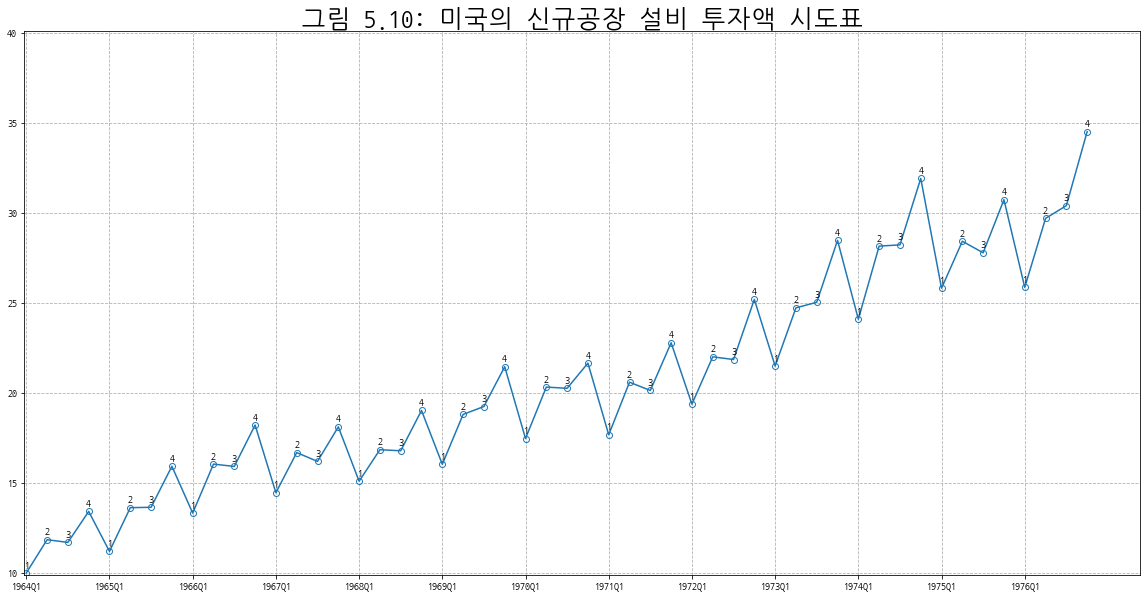

In [29]:
plt.title('그림 5.10: 미국의 신규공장 설비 투자액 시도표', fontsize=25)
plt.plot(df['z'], marker='o', markerfacecolor='none')
plt.xlim(-0.1)
plt.ylim(9.9, 40.1)
plt.xticks(df.index[::4])
plt.grid(True, linestyle='--')

for i in range(len(df)):
    height = df.iloc[i]['z']
    plt.text(df.index[i], height+0.3, df['분기'][i], ha='center')
    
plt.show()

## 표 5.14

In [30]:
# 추세차분
df['d=1'] = df['w'].diff(1)

# 계절차분
df['D=1'] = df['w'].diff(12)

# 계절, 추세차분
df['D=1,d=1'] = df['d=1'].diff(12)

In [31]:
df.head(5)

,연도,분기,z,w,d=1,D=1,"D=1,d=1"
1964Q1,1964,1,10.00,2.302585,NaN,NaN,NaN
1964Q2,1964,2,11.85,2.472328,0.169743,NaN,NaN
1964Q3,1964,3,11.70,2.459589,-0.012739,NaN,NaN
1964Q4,1964,4,13.42,2.596746,0.137157,NaN,NaN
1965Q1,1965,1,11.20,2.415914,-0.180832,NaN,NaN


### ①

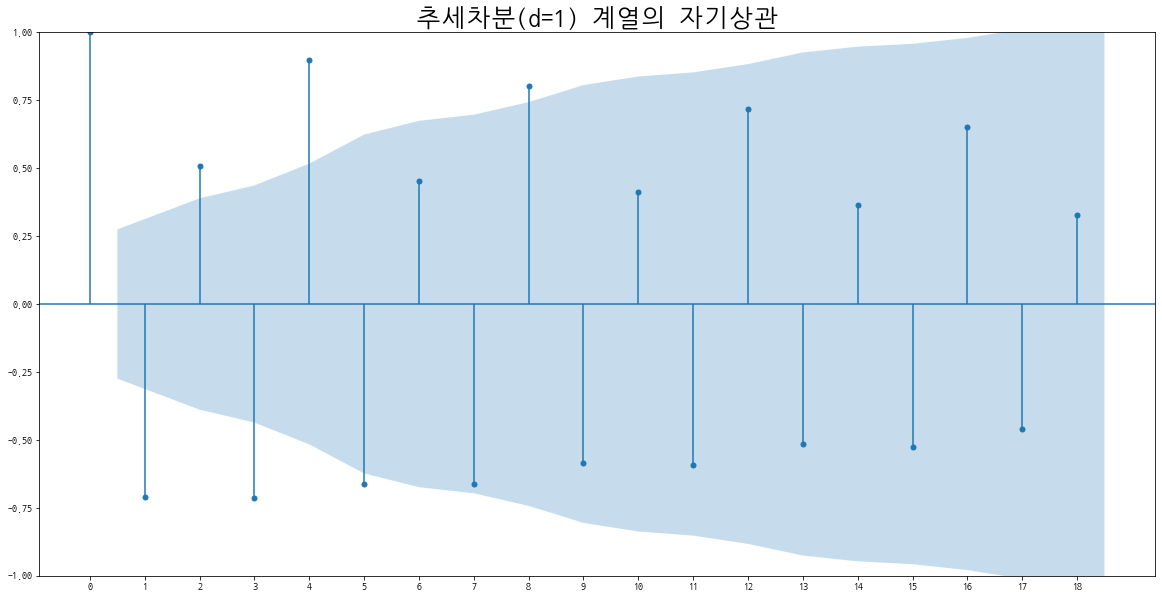

In [32]:
plot_acf(df['d=1'][1:])
plt.title('추세차분(d=1) 계열의 자기상관', fontsize=25)
plt.xticks(range(0, 19, 1))
plt.show()

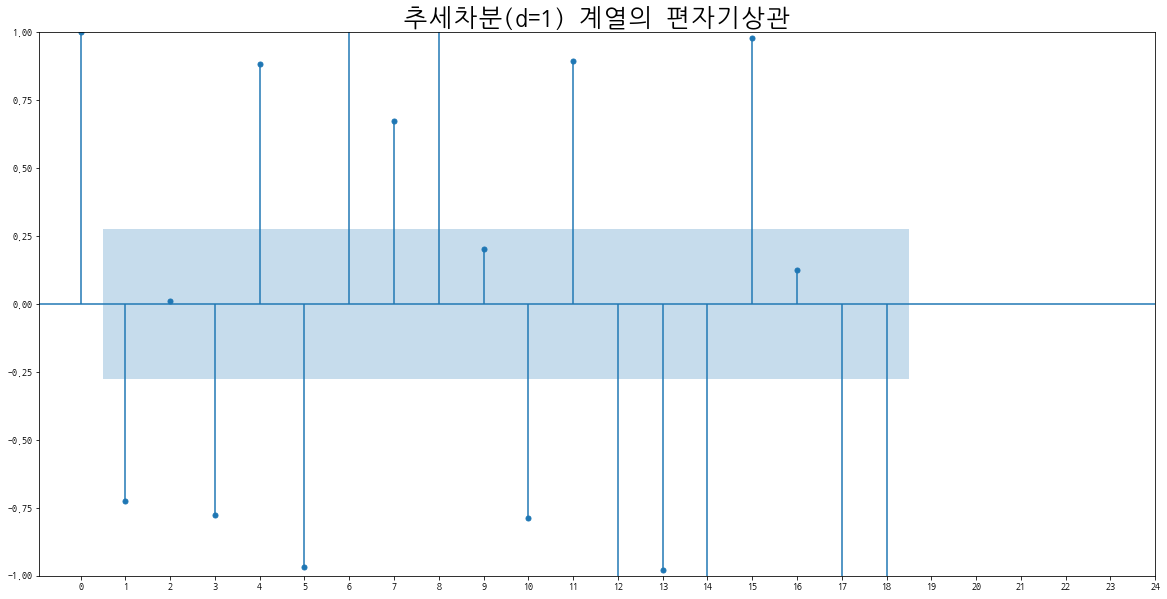

In [33]:
plot_pacf(df['d=1'][1:])
plt.title('추세차분(d=1) 계열의 편자기상관', fontsize=25)
plt.xticks(range(0, 25))
plt.show()

### ② 

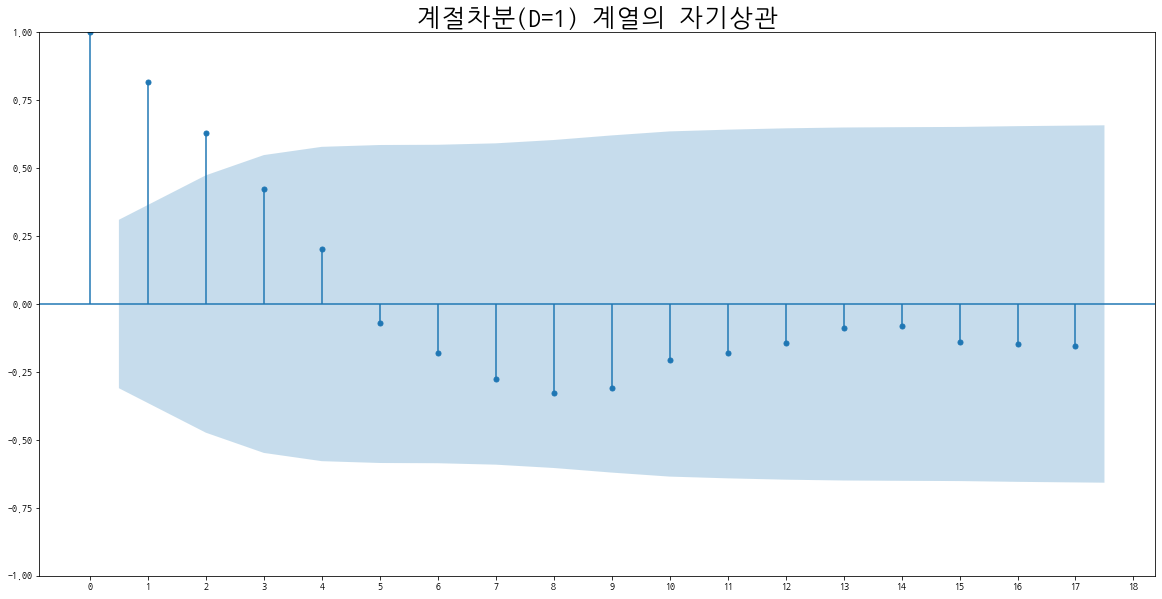

In [34]:
plot_acf(df['D=1'][12:])
plt.title('계절차분(D=1) 계열의 자기상관', fontsize=25)
plt.xticks(range(0, 19, 1))
plt.show()

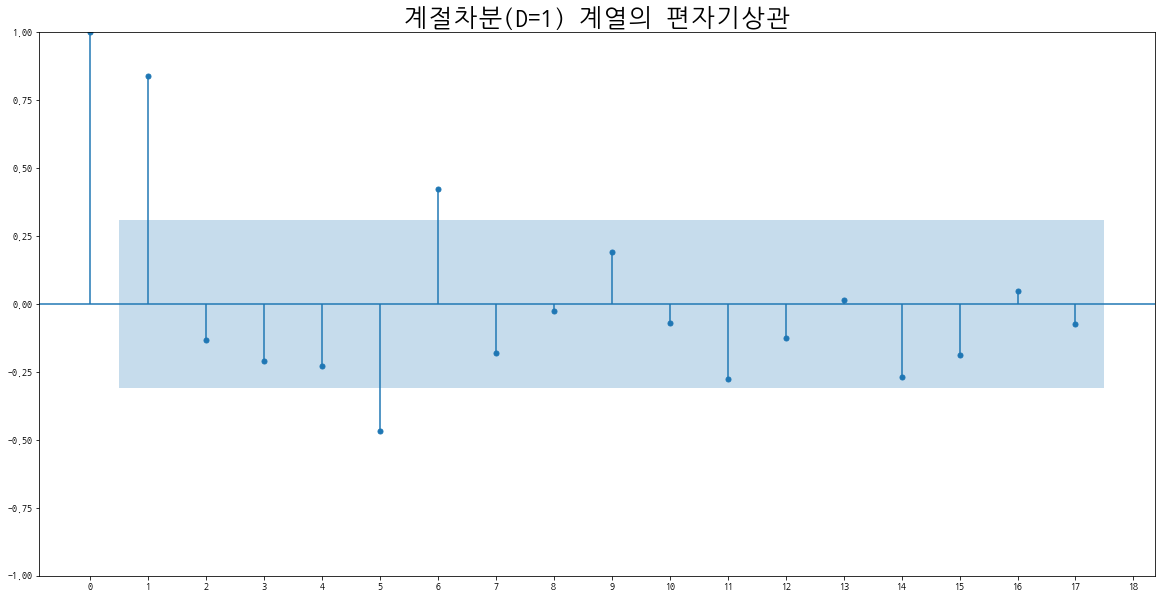

In [35]:
plot_pacf(df['D=1'][12:])
plt.title('계절차분(D=1) 계열의 편자기상관', fontsize=25)
plt.xticks(range(0, 19, 1))
plt.show()

### ③

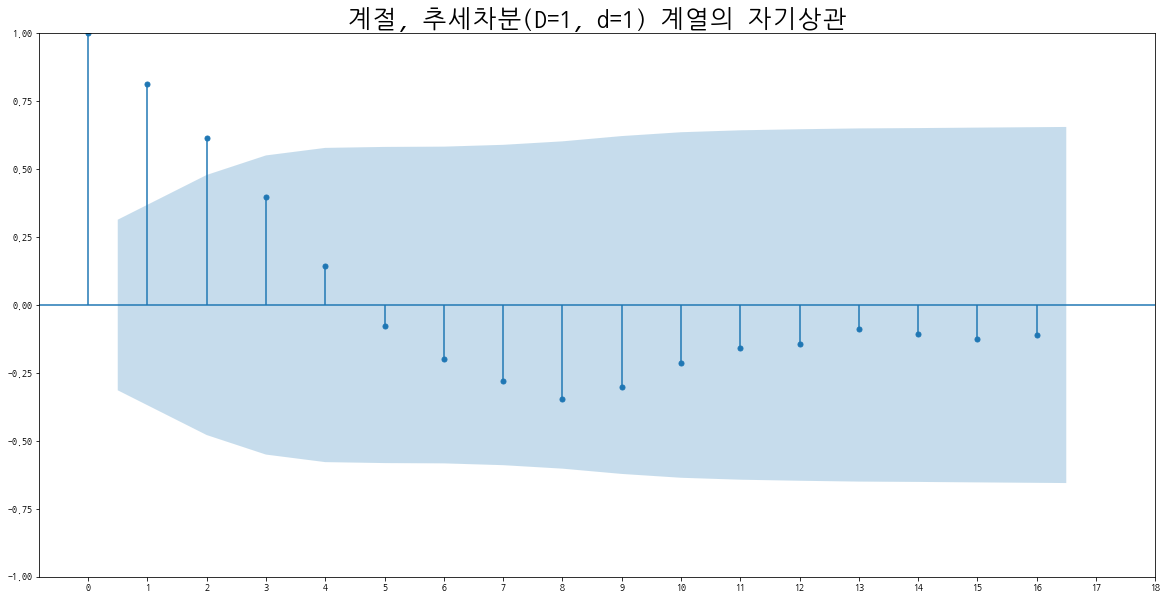

In [36]:
plot_acf(df['D=1'][13:])
plt.title('계절, 추세차분(D=1, d=1) 계열의 자기상관', fontsize=25)
plt.xticks(range(0, 19, 1))
plt.show()

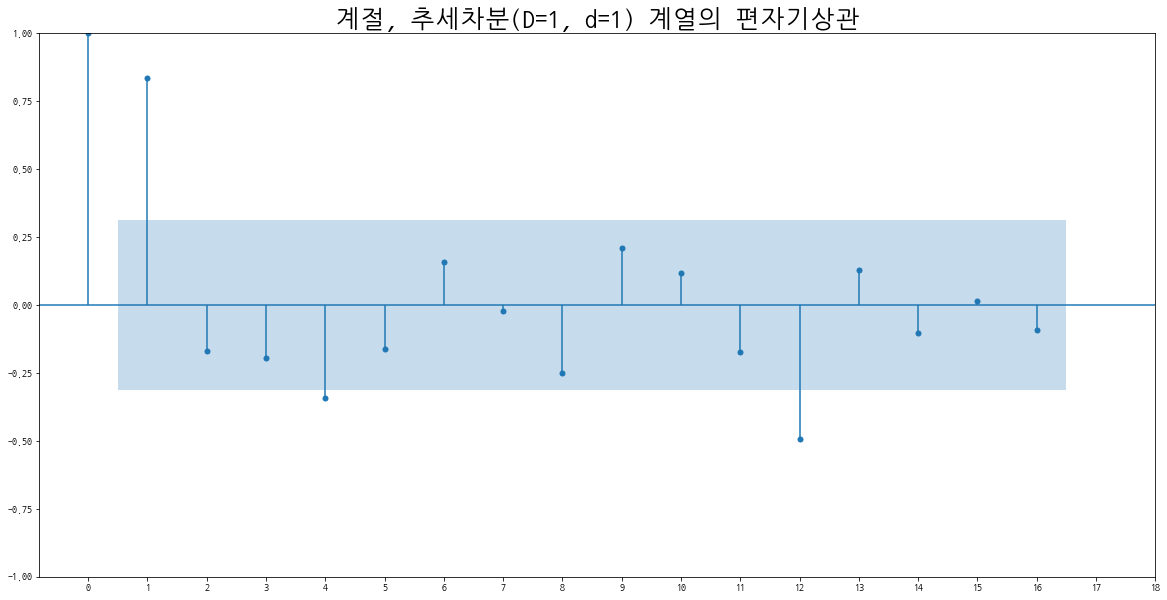

In [37]:
plot_pacf(df['D=1'][13:])
plt.title('계절, 추세차분(D=1, d=1) 계열의 편자기상관', fontsize=25)
plt.xticks(range(0, 19, 1))
plt.show()

### ④

In [38]:
model = sm.tsa.SARIMAX(df['w'], order=(1, 1, 0), seasonal_order=(0, 1, 2, 4), trend='c')
result = model.fit()
print(result.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.98666D+00    |proj g|=  9.94481D-01

At iterate    5    f= -2.01495D+00    |proj g|=  7.26218D+00

At iterate   10    f= -2.09199D+00    |proj g|=  3.22713D-01

At iterate   15    f= -2.10847D+00    |proj g|=  9.66236D-01

At iterate   20    f= -2.11526D+00    |proj g|=  1.40029D-01

At iterate   25    f= -2.11549D+00    |proj g|=  9.66068D-01

At iterate   30    f= -2.11914D+00    |proj g|=  1.54022D+00

At iterate   35    f= -2.12024D+00    |proj g|=  2.40197D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


### ⑤

In [39]:
# 모델의 잔차
residuals = result.resid

In [40]:
# 포트만트 검정
portmanteau = acorr_ljungbox(residuals, lags=24)
portmanteau

,lb_stat,lb_pvalue
1,0.040328,0.840841
2,0.042036,0.979202
3,0.053652,0.996748
4,10.643186,0.030881
5,10.647685,0.058831
6,10.648347,0.099872
7,10.650541,0.154605
8,10.653893,0.222092
9,10.653967,0.300175
10,10.653979,0.385104


In [41]:
portmanteau[::6]

,lb_stat,lb_pvalue
1,0.040328,0.840841
7,10.650541,0.154605
13,10.694310,0.636409
19,10.752566,0.931881


### ⑥

In [42]:
result.predict(start=1, end=4)

1964-04-01    2.302083
1964-07-01    2.471825
1964-10-01    2.459086
1965-01-01    3.747285
Freq: QS-OCT, Name: predicted_mean, dtype: float64

## 그림 5.11

In [43]:
df['forecast'] = np.exp(result.predict(data=df['w']).values)

In [44]:
df.head(5)

,연도,분기,z,w,d=1,D=1,"D=1,d=1",forecast
1964Q1,1964,1,10.00,2.302585,NaN,NaN,NaN,0.999498
1964Q2,1964,2,11.85,2.472328,0.169743,NaN,NaN,9.994975
1964Q3,1964,3,11.70,2.459589,-0.012739,NaN,NaN,11.844046
1964Q4,1964,4,13.42,2.596746,0.137157,NaN,NaN,11.694121
1965Q1,1965,1,11.20,2.415914,-0.180832,NaN,NaN,42.405785


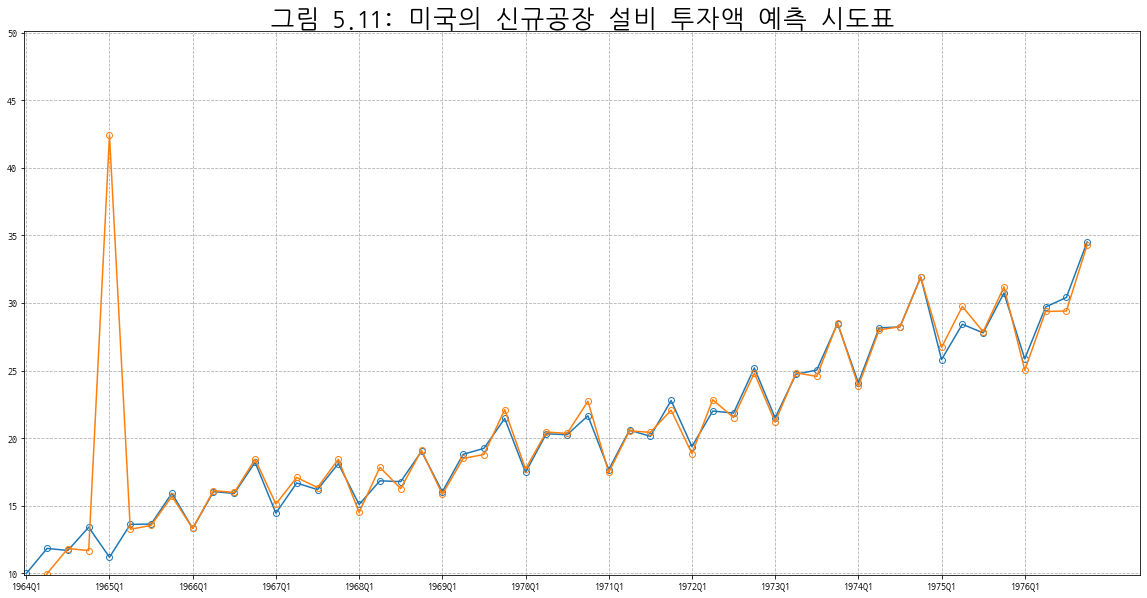

In [45]:
plt.title('그림 5.11: 미국의 신규공장 설비 투자액 예측 시도표', fontsize=25)
plt.plot(df['z'], marker='o', markerfacecolor='none')
plt.plot(df['forecast'], marker='o', markerfacecolor='none')
plt.xlim(-0.1)
plt.ylim(9.9, 50.1)
plt.xticks(df.index[::4])
plt.grid(True, linestyle='--')
    
plt.show()

## 표 5.15

In [46]:
order = [(1,1,0), (1,1,0), (0,1,1), (1,1,0), (1,1,0), 
         (0,1,1), (0,1,1), (2,1,0), (2,1,0), (0,1,2), 
         (0,1,2), (2,1,0), (2,1,0), (0,1,2), (0,1,2)]
seasonal_order = [(1,1,0,4), (0,1,1,4), (1,1,0,4), (0,1,1,4), (2,1,0,4), 
                  (0,1,2,4), (0,1,2,4), (1,1,0,4), (0,1,1,4), (1,1,0,4), 
                  (0,1,1,4), (2,1,0,4), (0,1,2,4), (2,1,0,4), (0,1,2,4)]

In [47]:
df_result = pd.DataFrame(columns=['모형', 'AIC'])

lst_model = []
lst_aic = []
for o, s in zip(order, seasonal_order):
    model = sm.tsa.SARIMAX(df['w'], order=o, seasonal_order=s)
    result = model.fit()
    
    lst_model.append('ARIMA'+'{}'.format(o)+'×'+'{}'.format(s))
    lst_aic.append(result.aic)
    
df_result['모형'] = lst_model
df_result['AIC'] = lst_aic

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.01449D+00    |proj g|=  2.47610D+00

At iterate    5    f= -2.01578D+00    |proj g|=  1.01553D-01

At iterate   10    f= -2.01678D+00    |proj g|=  1.62033D+00

At iterate   15    f= -2.01746D+00    |proj g|=  2.15961D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     32      1     0     0   2.160D-03  -2.017D+00
  F =  -2.0174627659080544     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -2.08368D+00    |proj g|=  2.32065D-01

At iterate   10    f= -2.08623D+00    |proj g|=  3.54581D+00

At iterate   15    f= -2.09336D+00    |proj g|=  3.33365D-02

At iterate   20    f= -2.09436D+00    |proj g|=  1.26955D+00

At iterate   25    f= -2.09526D+00    |proj g|=  2.38096D-03

At iterate   30    f= -2.09526D+00    |proj g|=  1.92011D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     63      1     0     0   1.920D-03  -2.095D+00
  F =  -2.0952600108407755     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.97548D+00    |proj g|=  2.50204D+00

At iterate    5    f= -1.98105D+00    |proj g|=  3.54765D+00

At iterate   10    f= -2.07594D+00    |proj g|=  2.10991D+00

At iterate   15    f= -2.08368D+00    |proj g|=  3.26377D+00

At iterate   20    f= -2.09602D+00    |proj g|=  1.28161D+00

At iterate   25    f= -2.09770D+00    |proj g|=  1.18476D+00

At iterate   30    f= -2.10870D+00    |proj g|=  1.88636D-01

At iterate   35    f= -2.10872D+00    |proj g|=  2.11598D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate   15    f= -2.08368D+00    |proj g|=  3.26377D+00

At iterate   20    f= -2.09602D+00    |proj g|=  1.28161D+00

At iterate   25    f= -2.09770D+00    |proj g|=  1.18476D+00

At iterate   30    f= -2.10870D+00    |proj g|=  1.88636D-01

At iterate   35    f= -2.10872D+00    |proj g|=  2.11598D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     85      2     0     0   2.116D-02  -2.109D+00
  F =  -2.1087248680084567     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.07356D+00    |proj g|=  7.99524D+00

At iterate    5    f= -2.08913D+00    |proj g|=  3.68353D-01

At iterate   10    f= -2.09730D+00    |proj g|=  4.23741D+00

At iterate   15    f= -2.10490D+00    |proj g|=  1.25407D-01

At iterate   20    f= -2.10985D+00    |proj g|=  6.76574D-02

At iterate   25    f= -2.11011D+00    |proj g|=  2.89906D-01

At iterate   30    f= -2.11025D+00    |proj g|=  9.93116D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -2.10057D+00    |proj g|=  3.47943D-02

At iterate   35    f= -2.10057D+00    |proj g|=  1.16135D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     59      1     0     0   1.216D-02  -2.101D+00
  F =  -2.1005684436955105     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.07930D+00    |proj g|=  1.03936D+01

At iterate    5    f= -2.10722D+00    |proj g|=  1.12848D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -2.11758D+00    |proj g|=  4.30835D+00

At iterate   15    f= -2.12134D+00    |proj g|=  2.21361D-01

At iterate   20    f= -2.12275D+00    |proj g|=  5.68567D-02

At iterate   25    f= -2.12411D+00    |proj g|=  3.38958D-02

At iterate   30    f= -2.12423D+00    |proj g|=  1.86219D-02

At iterate   35    f= -2.12425D+00    |proj g|=  6.45945D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     69      1     0     0   6.459D-02  -2.124D+00
  F =  -2.1242471994459660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


In [50]:
df_result

,모형,AIC
0,"ARIMA(1, 1, 0)×(1, 1, 0, 4)",-203.816128
1,"ARIMA(1, 1, 0)×(0, 1, 1, 4)",-211.907041
2,"ARIMA(0, 1, 1)×(1, 1, 0, 4)",-202.820735
3,"ARIMA(1, 1, 0)×(0, 1, 1, 4)",-211.907041
4,"ARIMA(1, 1, 0)×(2, 1, 0, 4)",-212.614947
5,"ARIMA(0, 1, 1)×(0, 1, 2, 4)",-211.307386
6,"ARIMA(0, 1, 1)×(0, 1, 2, 4)",-211.307386
7,"ARIMA(2, 1, 0)×(1, 1, 0, 4)",-202.015469
8,"ARIMA(2, 1, 0)×(0, 1, 1, 4)",-211.466420
9,"ARIMA(0, 1, 2)×(1, 1, 0, 4)",-201.252706


# 제 6절 부적절한 ARIMA 모형의 개선방법

In [64]:
df = pd.read_csv('./data/5장 - 계절형 ARIMA/표5.17-프로판가스의사용량자료.txt', header=None)

In [65]:
df.columns = ['z']

lst_year = []
for i in range(1, 11):
    for j in range(1, 5):
        lst_year.append(i)

lst_quarter = []
for i in range(10):
    for j in range(1, 5):
        lst_quarter.append(j)
        
df['연도'] = lst_year
df['분기'] = lst_quarter

df = df[['연도', '분기', 'z']]
df['D=1'] = df['z'].diff(4)

In [66]:
df

,연도,분기,z,D=1
0,1,1,344.39,NaN
1,1,2,246.63,NaN
2,1,3,131.53,NaN
3,1,4,288.87,NaN
4,2,1,313.45,-30.94
5,2,2,189.76,-56.87
6,2,3,179.10,47.57
7,2,4,221.10,-67.77
8,3,1,246.84,-66.61
9,3,2,209.00,19.24


## 그림 5.12

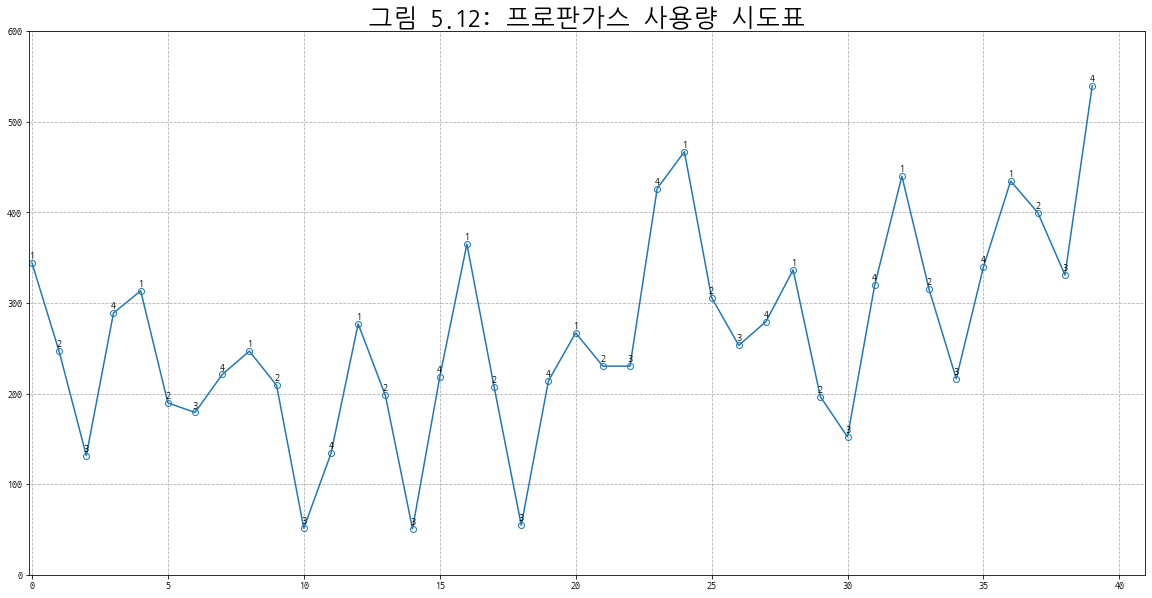

In [62]:
plt.title('그림 5.12: 프로판가스 사용량 시도표', fontsize=25)
plt.plot(df['z'], marker='o', markerfacecolor='none')
plt.xlim(-0.1)
plt.ylim(-0.1, 600.1)
plt.grid(True, linestyle='--')

for i in range(len(df)):
    height = df.iloc[i]['z']
    plt.text(df.index[i], height+5, df['분기'][i], ha='center')
    
plt.show()

## 표 5.18

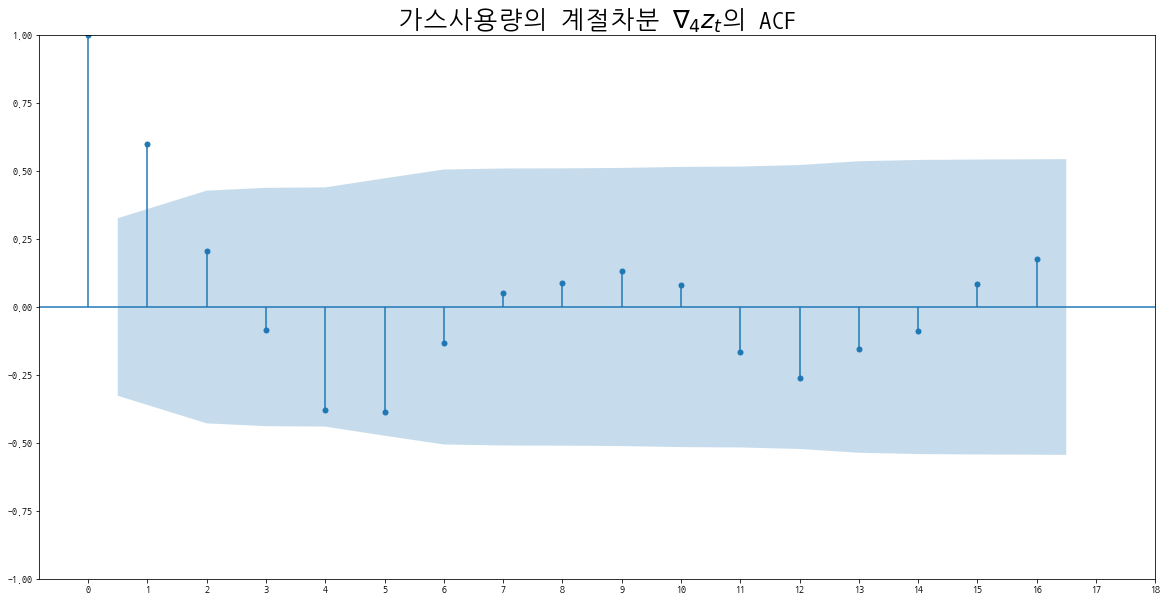

In [69]:
plot_acf(df['D=1'][4:])
plt.title('가스사용량의 계절차분 {}의 ACF'.format('$\\nabla_{4} z_{t}$'), fontsize=25)
plt.xticks(range(0, 19, 1))
plt.show()

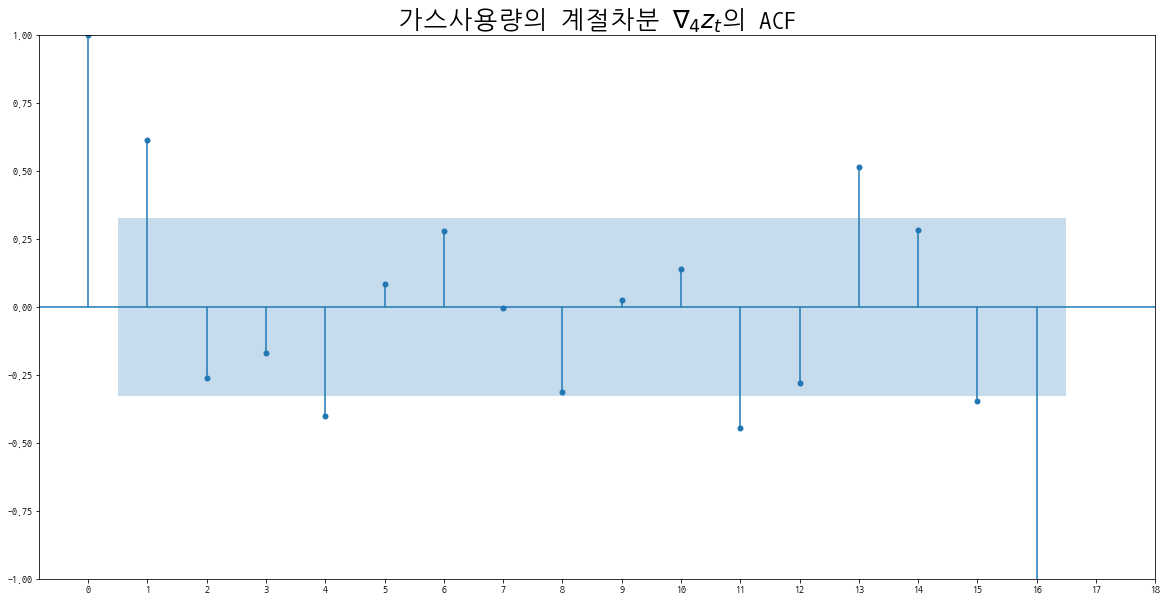

In [75]:
plot_pacf(df['D=1'][4:])
plt.title('가스사용량의 계절차분 {}의 ACF'.format('$\\nabla_{4} z_{t}$'), fontsize=25)
plt.xticks(range(0, 19, 1))
plt.show()